# Housing - Lineer Regression

sale_price prediction

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

from sklearn.linear_model import LinearRegression

sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 250)


## Tuning

In [220]:
# tuning params for mappings

building_category_mapping = ['FAMILY', 'APARTMENT', 'LUXURY', 'FACILITIES'] # maps building_class_category

# tuning params for outliers

# order: min, then quantile, then max !
sale_price_min = 1000 # min intuitive sale price, if -1, discarded
sale_price_lq = 0.01  # left quantile
sale_price_rq = 0.99  # right quantile
sale_price_max = -1   

#order: min, then quantile, then max
total_units_min = 0    # if -1, discarded
total_units_max = 10   # if -1, discarded
total_units_lq = 0.01
total_units_rq = 0.99

# order: min, then quantile, then max
gross_square_feet_min = -1     # if -1, discarded
gross_square_feet_max = -1     # if -1, discarded
gross_square_feet_lq = 0.05
gross_square_feet_rq = 0.95

land_square_feet_min = -1     # if -1, discarded
land_square_feet_max = -1     # if -1, discarded
land_square_feet_lq = 0.01
land_square_feet_rq = 0.99

# for categorial
neighborhood_min_len = 2  # minimum meaningful length
built_year_min = 1900

#
features_of_uninterested = ['sale_date', 'sale_month', 'sale_year', 
                            'sale_price']                           # eliminate these features
features_of_nondummies = ['borough', 'neighborhood', 
                               'building_class', 'building_class_map', 
                               'building_category', 'building_category_map', 
                               'building_type',
                               'tax_class', 'tax_class_map']        # eliminate these features 

In [221]:
# read all datasets w/ dates

filenames = glob.glob(os.path.join('dataset/housing/', 'r*.csv'))

#
li = []

for filename in filenames:
    df = pd.read_csv(filename, \
                dtype={'YEAR BUILT': int, 'BLOCK': object, 'LOT': object, 'ZIP CODE': object, 
                       'COMMERCIAL UNITS': object,
                       'BOROUGH': object, 'NEIGHBORHOOD': object, 'BUILDING CLASS CATEGORY': object,
                       'TAX CLASS AT PRESENT': object,  'EASE-MENT': object,
                       'BUILDING CLASS AT PRESENT': object, 'ADDRESS': object, 
                       'APART\nMENT\nNUMBER': object,
                       'RESIDENTIAL UNITS': object, 'COMMERCIAL UNITS': object, 'TOTAL UNITS': object,
                       'LAND SQUARE FEET': object, 'GROSS SQUARE FEET': object,
                       'TAX CLASS AT TIME OF SALE': object, 'BUILDING CLASS AT TIME OF SALE': object,
                       'SALE\nPRICE': str}, \
                parse_dates=['SALE DATE'], \
                infer_datetime_format=True)
    li.append(df)


raw_data = pd.concat(li, axis=0, ignore_index=True)


raw_data.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APART MENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1103,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$403,572",2013-07-09


# EDA stage

## Preperations
Apply all gains from _EDA stage

In [222]:
# change columns' order and names

data = raw_data.copy()

data.columns = ['borough', 'neighborhood', 'building_class_category',
                    'tax_class_at_present', 'block', 'lot', 'easement',
                    'building_class_at_present', 'address', 'apartment_number',
                    'zipcode', 'residential_units', 'commercial_units', 'total_units',
                    'land_square_feet', 'gross_square_feet', 'built_year',
                    'tax_class_at_sale', 'building_class_at_sale',
                    'sale_price', 'sale_date']

data.rename(columns={"building_class_category": "building_category"}, inplace=True)


data.head(1)

,borough,neighborhood,building_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,built_year,tax_class_at_sale,building_class_at_sale,sale_price,sale_date
0,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1103,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$403,572",2013-07-09


In [223]:
# Apply all gains from _EDA stage

data['borough'] = data['borough'].map({'1':'Manhattan', '3':'Brooklyn', '2':'Bronx', '4':'Queens', '5':'Staten Island'})  

data['sale_price'] = data['sale_price'].str.replace(r',|\$', '').astype(float)
data['neighborhood'] = data.neighborhood.str.split(r'(\s+)$', expand=True)[0]

#
data['building_category'] = data['building_category'].str.split(r'(\s+)$', expand=True)[0] \
                                                     .str.split(r'(^\S+)(\s+)', expand=True)[3]

for m in building_category_mapping:
    data.loc[data.building_category.str.contains(m, na=False), 'building_category_map'] = m
    
data.loc[data.building_category_map.isna(), 'building_category_map'] = 'OTHER'

#
data.rename(columns={"tax_class_at_present": "tax_class"}, inplace=True)
data.rename(columns={"tax_class_at_sale": "tax_class_map"}, inplace=True)

data['tax_class'] = data['tax_class'].str.replace(r'\s+', '').astype(object)
data['tax_class_map'] = data['tax_class_map'].str.replace(r'\s+', '').astype(object)

#
data.drop(['lot', 'block', 'easement'], axis=1, inplace=True)

#
data.drop(['building_class_at_present'], axis=1, inplace=True)

data.rename(columns={"building_class_at_sale": "building_class"}, inplace=True)

data['building_class'] = data['building_class'].str.replace(r'[^\S+]', '').astype(object)
data['building_class_map'] = data['building_class'].str[0:1]

#
data.drop(['apartment_number', 'address'], axis=1, inplace=True)

#
for col in ('residential_units', 'commercial_units', 'total_units'):
    data[col] = data[col].str.replace(r',', '').astype(int)


data.loc[(data.commercial_units == 0), 'building_type'] = 'RESIDENTIAL'
data.loc[(data.commercial_units > 0) & (data.residential_units == 0), 'building_type'] = 'COMMERCIAL'
data.loc[(data.commercial_units > 0) & (data.residential_units > 0), 'building_type'] = 'COMMERCIAL W/ RESIDENTIAL'

#
for col in ('land_square_feet', 'gross_square_feet'):
    data[col] = data[col].str.replace(r',', '').astype(int)

#
data['sale_month'] = data.sale_date.dt.month.astype(object)
data['sale_year'] = data.sale_date.dt.year.astype(object)


In [224]:
# change column order, in a meaningful way


data = data[['borough', 'neighborhood', 
             'building_class', 'building_class_map', 
             'building_category', 'building_category_map', 'building_type', 
             'tax_class', 'tax_class_map', 
             'zipcode',
             'residential_units', 'commercial_units', 'total_units',
             'land_square_feet', 'gross_square_feet', 
             'built_year',
             'sale_date', 'sale_month', 'sale_year',
             'sale_price']]

data.head(1)

,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,built_year,sale_date,sale_month,sale_year,sale_price
0,Brooklyn,,R1,R,CONDOS - 2-10 UNIT RESIDENTIAL,OTHER,RESIDENTIAL,,2,11220,0,0,0,0,0,0,2013-07-09,7,2013,403572.0


## Outliers
Apply EDA stage outliers' results

- log transformation w/ 0 values meaningless. so it is better to slice outliers, than transform



In [225]:
data_outliers = data.copy()

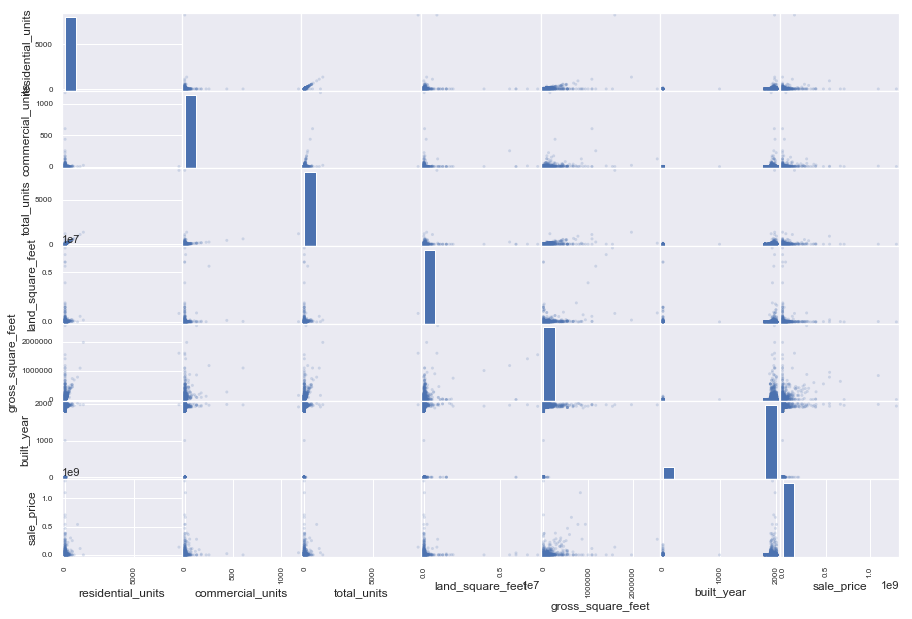

In [226]:
z = pd.plotting.scatter_matrix(data_outliers, alpha=0.2, figsize=(15, 10))

# at diagonal, all numerical features have outliers!

### sale_price
- missing or 0 values has to be eliminated. that's a sales data
- then, outliers eliminated

In [227]:
if (sale_price_min != -1):
    data_outliers = data_outliers[data_outliers.sale_price >= sale_price_min]


sale_price_min, len(data), len(data_outliers)

(1000, 85975, 56012)

In [228]:
q1 = data_outliers.sale_price.quantile(sale_price_lq)
q2 = data_outliers.sale_price.quantile(sale_price_rq)

data_outliers = data_outliers[(data_outliers.sale_price > q1) & (data_outliers.sale_price < q2)]

q1, q2, len(data), len(data_outliers)

(13047.0, 12000000.0, 85975, 54860)

In [229]:
if (sale_price_max != -1):
    data_outliers = data_outliers[data_outliers.sale_price <= sale_price_max]
    
sale_price_max, len(data), len(data_outliers)

(-1, 85975, 54860)

In [230]:
# check Zero values for transformation

data_outliers[data_outliers.sale_price == 0].head()[['sale_price']]

,sale_price


### land_square_feet, gross_square_feet
- missing or Zero values kept as is
- outliers eliminated

In [231]:
if (gross_square_feet_min != -1):
    data_outliers = data_outliers[(data_outliers.gross_square_feet > gross_square_feet_min)]
    
if (land_square_feet_min != -1):
    data_outliers = data_outliers[(data_outliers.land_square_feet > land_square_feet_min)]

land_square_feet_min, gross_square_feet_min, len(data), len(data_outliers)

(-1, -1, 85975, 54860)

In [232]:
q1 = data_outliers.gross_square_feet.quantile(gross_square_feet_lq)
q2 = data_outliers.gross_square_feet.quantile(gross_square_feet_rq)

data_outliers = data_outliers[(data_outliers.gross_square_feet > q1) & (data_outliers.gross_square_feet < q2)]

q1, q2, len(data), len(data_outliers)

(0.0, 7800.0, 85975, 22092)

In [233]:
q1 = data_outliers.land_square_feet.quantile(land_square_feet_lq)
q2 = data_outliers.land_square_feet.quantile(land_square_feet_rq)

data_outliers = data_outliers[(data_outliers.land_square_feet > q1) & (data_outliers.land_square_feet < q2)]

q1, q2, len(data), len(data_outliers)

(935.91, 11250.0, 85975, 21649)

In [234]:
if (gross_square_feet_max != -1):
    data_outliers = data_outliers[(data_outliers.gross_square_feet < gross_square_feet_max)]
    
if (land_square_feet_max != -1):
    data_outliers = data_outliers[(data_outliers.land_square_feet < land_square_feet_max)]
    
land_square_feet_min, gross_square_feet_min, len(data), len(data_outliers)   

(-1, -1, 85975, 21649)

### residential_units, commercial_units, total_units
- total_units = residential_units + comercial_units

In [235]:
if (total_units_min != -1):
    data_outliers = data_outliers[(data_outliers.total_units > total_units_min)]


total_units_min, len(data), len(data_outliers) 

(0, 85975, 21608)

In [236]:
q1 = data_outliers.total_units.quantile(total_units_lq)
q2 = data_outliers.total_units.quantile(total_units_rq)

data_outliers = data_outliers[(data_outliers.total_units > q1) & (data_outliers.total_units < q2)]

q1, q2, len(data), len(data_outliers)

(1.0, 8.0, 85975, 11897)

In [237]:
if (total_units_max != -1):
    data_outliers = data_outliers[(data_outliers.total_units < total_units_max)]

total_units_max, len(data), len(data_outliers) 

(10, 85975, 11897)

### built_year

In [238]:
if (built_year_min != -1):
    data_outliers = data_outliers[(data_outliers.built_year >= built_year_min)]

len(data), len(data_outliers)

(85975, 10920)

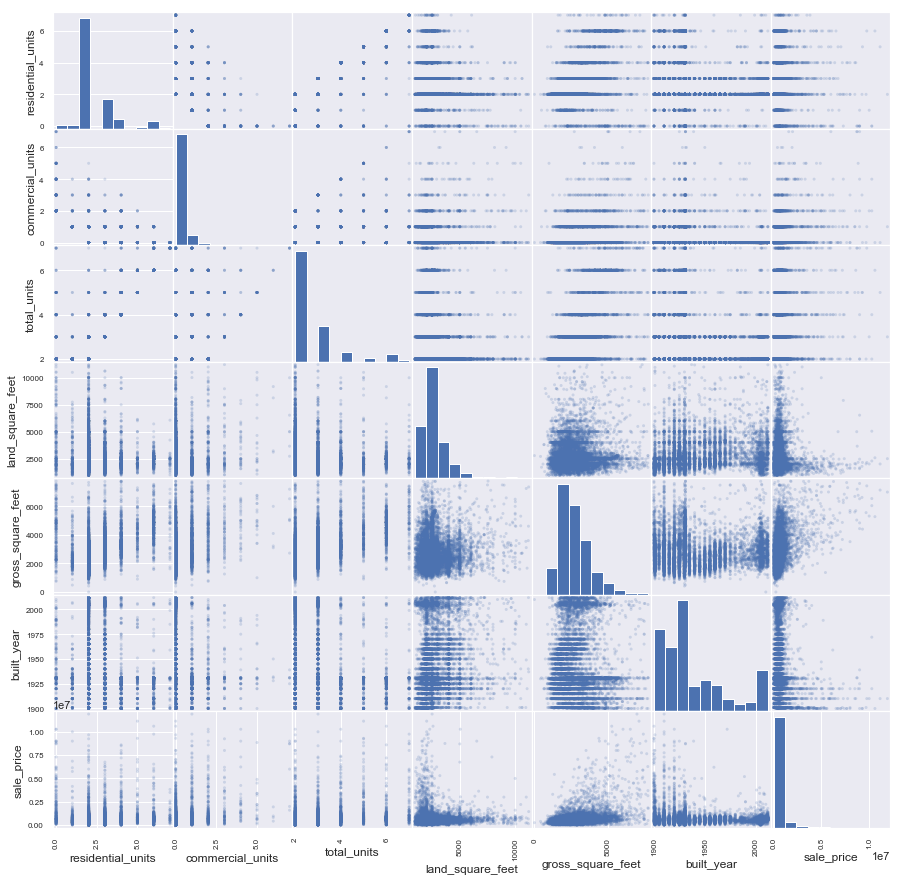

In [239]:
z = pd.plotting.scatter_matrix(data_outliers, alpha=0.2, figsize=(15, 15))

# more tuned than ever

# Preprocessing for ML

- transformations, if needed
- check assumptions (OLS for linear reg.)
- create dummy features
- check assumptions w/ dummy again

## transformations

In [240]:
data_cleaned = data_outliers.copy().reset_index(drop=True)

In [241]:
# zeros problem in log transformation. so it is vital how to handle them in numerical features.

data_cleaned['log_sale_price'] = np.log(data_cleaned.sale_price)

data_cleaned['log_gross_square_feet'] = np.log(data_cleaned.gross_square_feet)
data_cleaned['log_land_square_feet'] = np.log(data_cleaned.land_square_feet)


In [242]:
data_cleaned = data_cleaned[['borough', 'neighborhood', 
                               'building_class', 'building_class_map', 
                               'building_category', 'building_category_map', 'building_type',
                               'tax_class', 'tax_class_map', 
                               'residential_units', 'commercial_units', 'total_units', 
                               'land_square_feet', 'log_land_square_feet', 'gross_square_feet', 'log_gross_square_feet', 
                               'built_year', 
                               'sale_date', 'sale_month', 'sale_year',
                               'sale_price', 'log_sale_price']]

data_cleaned.head(1)


,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,residential_units,commercial_units,total_units,land_square_feet,log_land_square_feet,gross_square_feet,log_gross_square_feet,built_year,sale_date,sale_month,sale_year,sale_price,log_sale_price
0,Brooklyn,BATH BEACH,S1,S,ONE FAMILY HOMES,FAMILY,COMMERCIAL W/ RESIDENTIAL,1,1,1,1,2,2707,7.903596,3304,8.102889,1960,2012-11-29,11,2012,820000.0,13.61706


### Features of Interest

we only need either numerical or categorical features.

In [243]:
data_cleaned.dtypes, features_of_uninterested

(borough                          object
 neighborhood                     object
 building_class                   object
 building_class_map               object
 building_category                object
 building_category_map            object
 building_type                    object
 tax_class                        object
 tax_class_map                    object
 residential_units                 int64
 commercial_units                  int64
 total_units                       int64
 land_square_feet                  int64
 log_land_square_feet            float64
 gross_square_feet                 int64
 log_gross_square_feet           float64
 built_year                        int64
 sale_date                datetime64[ns]
 sale_month                       object
 sale_year                        object
 sale_price                      float64
 log_sale_price                  float64
 dtype: object, ['sale_date', 'sale_month', 'sale_year', 'sale_price'])

In [244]:
data_cleaned.drop(features_of_uninterested, axis=1, inplace=True)

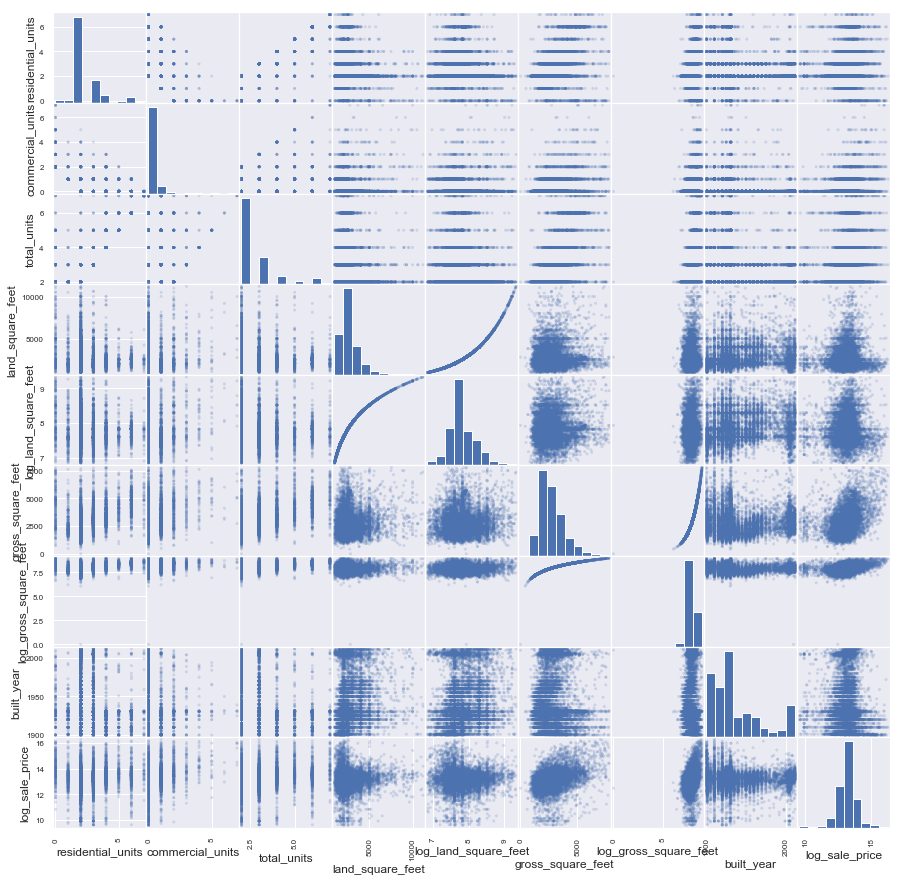

In [245]:
z = pd.plotting.scatter_matrix(data_cleaned, alpha=0.2, figsize=(15, 15))

# at diagonal, all numerical features has outliers!
# after log transform, 
# - sale_price becomes normal distribution
# - land_square_feet (no outlier ops. done) becomes normal distribution. But gross_square_feet, has left skewed!

## Checking OLS Assumptions

### multicollinearity

- 'residential_units', 'commercial_units', 'total_units', and 'built_year' has >10, so drop them.
- 'land_square_feet', 'gross_square_feet', are ok. So take log_ versions and drop them


In [462]:
data_no_multicollinearity = data_cleaned.copy()

In [463]:
data_no_multicollinearity.dtypes

borough                   object
neighborhood              object
building_class            object
building_class_map        object
building_category         object
building_category_map     object
building_type             object
tax_class                 object
tax_class_map             object
residential_units          int64
commercial_units           int64
total_units                int64
land_square_feet           int64
log_land_square_feet     float64
gross_square_feet          int64
log_gross_square_feet    float64
built_year                 int64
log_sale_price           float64
dtype: object

In [464]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

## dummy variables are not included yet! This will effects VIF!
variables = data_no_multicollinearity[['residential_units', 'commercial_units', 'total_units', 
                                       'log_land_square_feet', 
                                       'log_gross_square_feet',
                                       #'built_year'
                                     ]]

vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['features'] = variables.columns

vif

# take log_gross_square_feet

,VIF,features
0,6650.501784,residential_units
1,326.488166,commercial_units
2,7461.042120,total_units
3,273.530249,log_land_square_feet
4,321.027782,log_gross_square_feet


In [465]:
data_no_multicollinearity.columns.values

array(['borough', 'neighborhood', 'building_class', 'building_class_map',
       'building_category', 'building_category_map', 'building_type',
       'tax_class', 'tax_class_map', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'log_land_square_feet', 'gross_square_feet',
       'log_gross_square_feet', 'built_year', 'log_sale_price'],
      dtype=object)

In [466]:
data_no_multicollinearity.drop(['residential_units', 'commercial_units', 'total_units', 
                                'land_square_feet', 'gross_square_feet', 
                                #'log_land_square_feet',
                                'built_year'], axis=1, inplace=True)

data_no_multicollinearity.head(1)

,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,log_land_square_feet,log_gross_square_feet,log_sale_price
0,Brooklyn,BATH BEACH,S1,S,ONE FAMILY HOMES,FAMILY,COMMERCIAL W/ RESIDENTIAL,1,1,7.903596,8.102889,13.61706


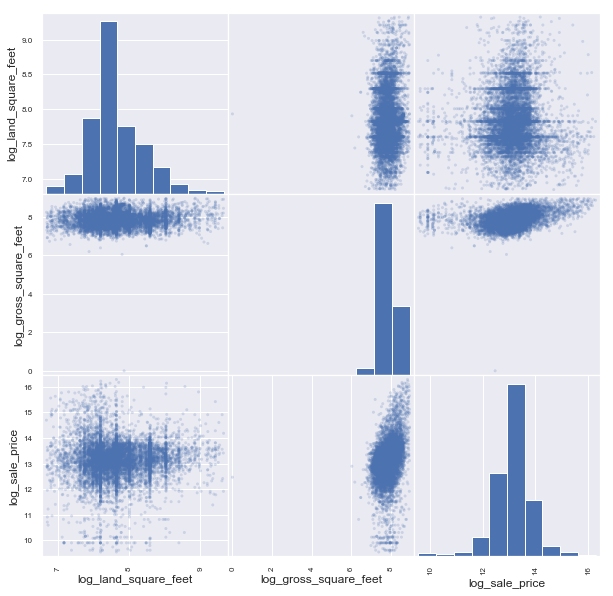

In [467]:
z = pd.plotting.scatter_matrix(data_no_multicollinearity, alpha=0.2, figsize=(10, 10))

## Dummy Variables

In [496]:
data_with_dummies = data_no_multicollinearity.copy()

In [497]:
data_with_dummies.dtypes

borough                   object
neighborhood              object
building_class            object
building_class_map        object
building_category         object
building_category_map     object
building_type             object
tax_class                 object
tax_class_map             object
log_land_square_feet     float64
log_gross_square_feet    float64
log_sale_price           float64
dtype: object

In [498]:
data_with_dummies.describe(include='all')

,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,log_land_square_feet,log_gross_square_feet,log_sale_price
count,10920,10920,10920,10920,10920,10920,10920,10920,10920,10920.000000,10920.000000,10920.000000
unique,5,232,56,19,22,4,3,5,3,NaN,NaN,NaN
top,Brooklyn,BUSHWICK,B1,B,TWO FAMILY HOMES,FAMILY,RESIDENTIAL,1,1,NaN,NaN,NaN
freq,4721,444,2219,6755,7120,9149,9678,9170,9160,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.823509,7.843974,13.142639
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382013,0.380848,0.734514
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.843750,0.000000,9.546813
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.600902,7.583248,12.818552
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.785305,7.828038,13.169388
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.006368,8.095599,13.527828


In [499]:
data_with_dummies.head(1)

,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,log_land_square_feet,log_gross_square_feet,log_sale_price
0,Brooklyn,BATH BEACH,S1,S,ONE FAMILY HOMES,FAMILY,COMMERCIAL W/ RESIDENTIAL,1,1,7.903596,8.102889,13.61706


In [500]:
features_of_nondummies = [ 'neighborhood', 'building_class', 'building_class_map', 'building_category', 'building_category_map',
                           'building_type', 'tax_class']

# 'borough', 'tax_class_map'

data_with_dummies.drop(features_of_nondummies, axis=1, inplace=True)

data_with_dummies.head(1)


,borough,tax_class_map,log_land_square_feet,log_gross_square_feet,log_sale_price
0,Brooklyn,1,7.903596,8.102889,13.61706


## create dummy variables

In [501]:
# lst element is log_sale_price, take it to the beginning

cols = data_with_dummies.columns.tolist()
cols = cols[-1:] + cols[:-1]

data_with_dummies = data_with_dummies[cols]

data_with_dummies.head(1)

,log_sale_price,borough,tax_class_map,log_land_square_feet,log_gross_square_feet
0,13.61706,Brooklyn,1,7.903596,8.102889


In [502]:
data_with_dummies = pd.get_dummies(data_with_dummies, drop_first=True)

data_with_dummies.head()

,log_sale_price,log_land_square_feet,log_gross_square_feet,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,tax_class_map_2,tax_class_map_4
0,13.617060,7.903596,8.102889,1,0,0,0,0,0
1,13.217674,7.066467,7.495542,1,0,0,0,0,0
2,14.350365,8.955061,8.538367,1,0,0,0,0,0
3,13.696727,7.574558,8.058327,1,0,0,0,0,0
4,13.458836,7.776115,7.715124,1,0,0,0,0,0


## Multicollinearity w/ dummies

In [503]:
data_preprocessed = data_with_dummies.copy()

data_preprocessed.head(2)

,log_sale_price,log_land_square_feet,log_gross_square_feet,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,tax_class_map_2,tax_class_map_4
0,13.617060,7.903596,8.102889,1,0,0,0,0,0
1,13.217674,7.066467,7.495542,1,0,0,0,0,0


In [504]:
data_preprocessed.columns.values

array(['log_sale_price', 'log_land_square_feet', 'log_gross_square_feet',
       'borough_Brooklyn', 'borough_Manhattan', 'borough_Queens',
       'borough_Staten Island', 'tax_class_map_2', 'tax_class_map_4'],
      dtype=object)

In [505]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

cols = data_preprocessed.columns.values[1:]  # log_sale_price (target) except. all log_*

## + dummy variables added
variables = data_preprocessed[cols]

vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['features'] = variables.columns

vif

#  ln(266) = 5.58
#  ln(241) = 5.48

,VIF,features
0,332.462220,log_land_square_feet
1,336.883083,log_gross_square_feet
2,4.812530,borough_Brooklyn
3,1.361442,borough_Manhattan
4,4.107749,borough_Queens
5,1.816415,borough_Staten Island
6,1.363263,tax_class_map_2
7,1.077161,tax_class_map_4


# Regression

- log_land_square_feet: R-squared = %0.03, adjusted-R-squared = %0.019
- log_land_square_feet, log_gross_square_feet:  R-squared = %10, adjusted-R-squared = %10
- log_land_square_feet, log_gross_square_feet, dummy(building_category_map):  R-squared = %12, adjusted-R-squared = %12
- log_gross_square_feet, dummy(borough):  R-squared = %20, adjusted-R-squared = %20
    - .. dummy(+building_category_map):  R-squared = %21, adjusted-R-squared = %21
    - .. dummy(+tax_class_map):  R-squared = %21, adjusted-R-squared = %21
    - 
- log_gross_square_feet, dummy(neighborhood):  R-squared = %44, adjusted-R-squared = %43
    - .. dummy(+building_class):  R-squared = %46, adjusted-R-squared = %44 (less prediction power increase)
    - .. dummy(+building_class_map):  R-squared = %45, adjusted-R-squared = %44 (less prediction power increase)
    - +log_land_square_feet .. dummy(+building_class_map):  R-squared = %46, adjusted-R-squared = %44 (less prediction power increase)
    - 
    

In [506]:
data_preprocessed.columns.values

array(['log_sale_price', 'log_land_square_feet', 'log_gross_square_feet',
       'borough_Brooklyn', 'borough_Manhattan', 'borough_Queens',
       'borough_Staten Island', 'tax_class_map_2', 'tax_class_map_4'],
      dtype=object)

In [507]:
targets = data_preprocessed[data_preprocessed.columns.values[0:1]]

inputs = data_preprocessed[data_preprocessed.columns.values[1:]]  # except target features

inputs.shape, targets.shape

((10920, 8), (10920, 1))

## feature scaling

In [508]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(inputs)

inputs_scaled = scaler.transform(inputs)

inputs_scaled[0:3]

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  import sys


array([[ 0.20965476,  0.67986914,  1.14589234, -0.16691748, -0.73468572,
        -0.28830267, -0.38552215, -0.18116138],
       [-1.98181   , -0.91492893,  1.14589234, -0.16691748, -0.73468572,
        -0.28830267, -0.38552215, -0.18116138],
       [ 2.96221365,  1.82336654,  1.14589234, -0.16691748, -0.73468572,
        -0.28830267, -0.38552215, -0.18116138]])

## train - test split

In [509]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365) 

## create regression

In [510]:
reg = LinearRegression()

reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [511]:
print('r-squared:', reg.score(x_train, y_train),
      '\nadjusted r-squared:', 1- (1-reg.score(x_train, y_train)) * (x_train.shape[0]-1) / (x_train.shape[0]-x_train.shape[1]-1))


r-squared: 0.21826246715717568 
adjusted r-squared: 0.2175458520245136


## check train model

In [512]:
y_hat_train = reg.predict(x_train)

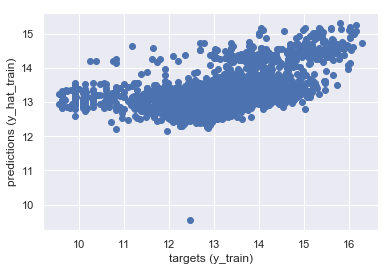

In [513]:
plt.scatter(y_train, y_hat_train)
plt.xlabel('targets (y_train)')
plt.ylabel('predictions (y_hat_train)')

plt.xlim()
plt.ylim()

plt.show()

# expected 45 degrees 